In [1]:
!pip install scikit-learn

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
import math
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, mean_squared_error
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForMaskedLM
import random
from sklearn.preprocessing import OneHotEncoder as Encoder
from sklearn.metrics import f1_score

In [2]:
BATCH_SIZE = 128
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
EPOCHS = 4

In [3]:
!wget https://raw.githubusercontent.com/kugi8412/DL-Life-Science/refs/heads/main/train_data.tsv -O train_data.tsv

df = pd.read_csv('train_data.tsv', sep='\t')
df.head()

--2025-04-14 20:20:39--  https://raw.githubusercontent.com/kugi8412/DL-Life-Science/refs/heads/main/train_data.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13382819 (13M) [text/plain]
Saving to: ‘train_data.tsv’

train_data.tsv      100%[===================>]  12.76M  77.2MB/s    in 0.2s    

2025-04-14 20:20:41 (77.2 MB/s) - ‘train_data.tsv’ saved [13382819/13382819]



,insert_chrom,insert_name,sequence,rna_dna_ratio,is_active
0,chr16,chr16:22572551-22572821,GTTCTCTATGCCATCTCACATTTATCCCCAAAGCCCAGGGAGGCTG...,1.179811,1
1,chr18,chr18:46761035-46761305,CAAAACATGGAGGTCTGAAGTCCCTTTTGTTCCTATCAGTATGGAG...,1.406439,1
2,chr1,chr1:209485218-209485488,TGTGGGAACAAGGAAGGAGTTAAGTTGGCATAAGCAGTTTAATAAG...,1.021255,0
3,chr3,chr3:45119427-45119697,TGCCCTATCTTGGATTCTGATTATGAGTCTCCGGGCAGCTGATGGC...,0.817915,0
4,chr14,chr14:51481635-51481905,GGTTTCCTTCGATCACCCAAGCTGGCTATTATTATCGTTCTTACAC...,0.756986,0


In [4]:
val_chroms = ['chr10', 'chr11']
train_df = df[~df['insert_chrom'].isin(val_chroms)]
val_df = df[df['insert_chrom'].isin(val_chroms)]

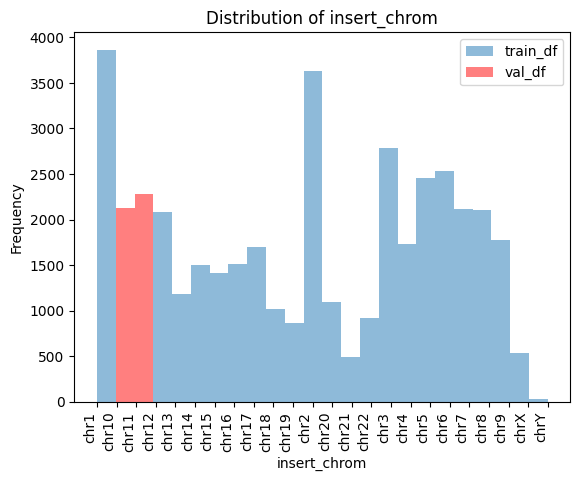

In [20]:
chrom_to_label = {chrom: i for i, chrom in enumerate(np.unique(np.concatenate([train_df['insert_chrom'], val_df['insert_chrom']])))}

train_df.loc[:, 'insert_chrom_label'] = train_df['insert_chrom'].map(chrom_to_label)
val_df.loc[:, 'insert_chrom_label'] = val_df['insert_chrom'].map(chrom_to_label)
bins = np.histogram_bin_edges(np.concatenate([train_df['insert_chrom_label'], val_df['insert_chrom_label']]), bins=24)

plt.hist(train_df['insert_chrom_label'], bins=bins, alpha=0.5, label='train_df')
plt.hist(val_df['insert_chrom_label'], bins=bins, alpha=0.5, color='red', label='val_df')
plt.xlabel('insert_chrom')
plt.ylabel('Frequency')
plt.title('Distribution of insert_chrom')
plt.xticks(ticks=range(len(chrom_to_label)), labels=chrom_to_label.keys(), rotation=90, ha='right')
plt.legend(loc='upper right')
plt.show()

<Axes: >

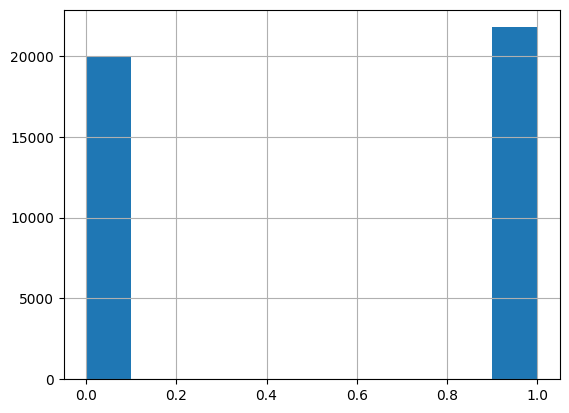

In [21]:
# Dataset are balnced
df['is_active'].hist()

<Axes: >

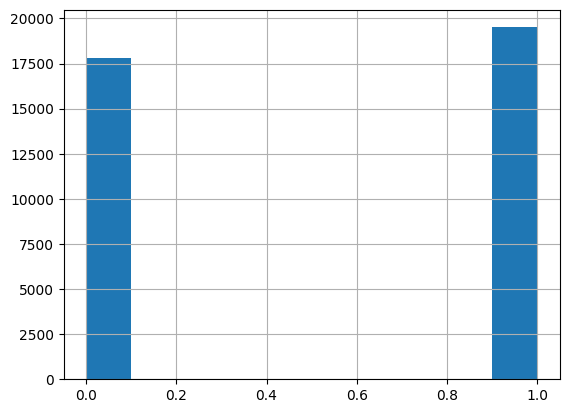

In [22]:
train_df['is_active'].hist()

<Axes: >

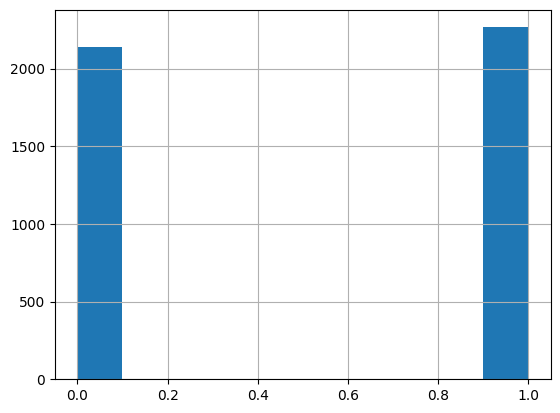

In [23]:
val_df['is_active'].hist()

<Axes: >

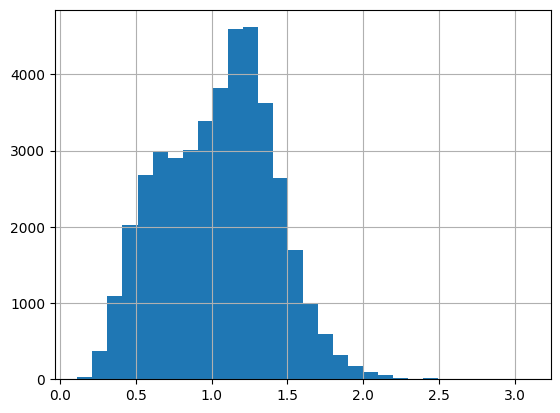

In [24]:
# Histogram of continous values
df['rna_dna_ratio'].hist(bins=30)

<Axes: >

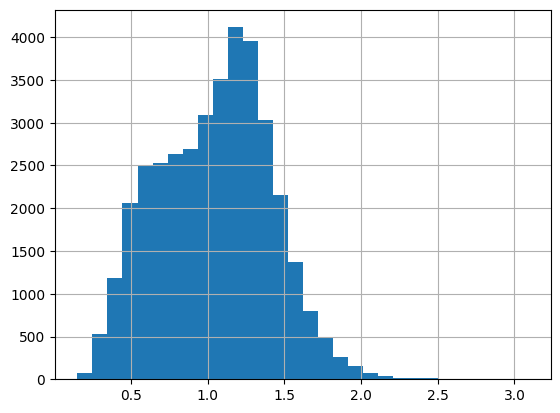

In [25]:
train_df['rna_dna_ratio'].hist(bins=30)

<Axes: >

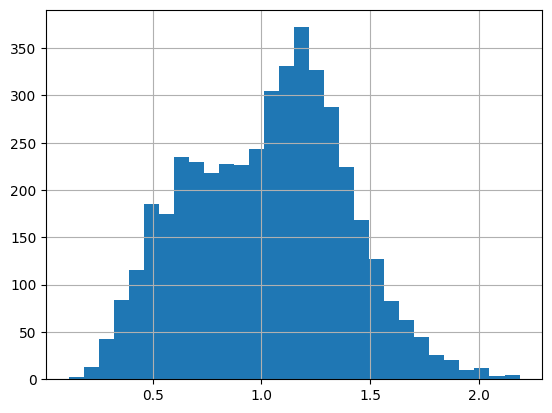

In [26]:
val_df['rna_dna_ratio'].hist(bins=30)

In [27]:
# Sanity check of sequence length
df['sequence_length'] = df['sequence'].apply(len)
print(df['sequence_length'].unique())

[271]


In [5]:
class OHEncoder:
    def __init__(self, categories=np.array(['A', 'C', 'G', 'T'])):
        self.encoder = Encoder(sparse_output=False, categories=[categories])
        self.dictionary = categories
        self.encoder.fit(categories.reshape(-1, 1))

    def __call__(self, seq, info=False):
        seq = list(seq)
        # Jeśli w sekwencji występuje znak 'N', w naszych danych nie ma, ale może być
        if 'N' in seq:
            pos = [i for i, el in enumerate(seq) if el == 'N']
            for p in pos:
                seq[p] = random.choice(self.dictionary)

        s = np.array(seq).reshape(-1, 1)
        encoded = self.encoder.transform(s).T  # wynik: macierz (4, seq_len)
        return torch.tensor(encoded).unsqueeze(0).unsqueeze(0).float()

In [6]:
class CustomCNNEncoder(nn.Module):
    def __init__(self, seq_len=271, num_channels=[100, 50, 50], kernel_widths=[9, 7, 3],
                 pooling_widths=[3, 4, 4], num_units=[2000, 64], dropout=0.75):
        """ Ta sieć przetwarza 2D one-hot zakodowaną sekwencję.
        Wynik (wektor cech) ma wymiar num_units[-1].
        """
        super(CustomCNNEncoder, self).__init__()
        paddings = [int((w - 1) / 2) for w in kernel_widths]
        self.seq_len = seq_len

        conv_modules = []
        # Wejście: jeden kanał (obraz o rozmiarze 1 x (4, seq_len))
        num_channels_in = [1] + num_channels
        for num, (in_chan, out_chan, kernel, padding, pool) in \
                enumerate(zip(num_channels_in[:-1], num_channels_in[1:], kernel_widths, paddings, pooling_widths)):
            k = 4 if num == 0 else 1
            conv_modules += [
                nn.Conv2d(in_chan, out_chan, kernel_size=(k, kernel), padding=(0, padding)),
                nn.BatchNorm2d(out_chan),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=(1, pool), ceil_mode=True)
            ]
            seq_len = math.ceil(seq_len / pool)
        self.conv_layers = nn.Sequential(*conv_modules)
        self.conv_out_size = 1 * seq_len * num_channels_in[-1]

        # Wspólna głowica FC – ekstraktor cech
        fc_layers = []
        num_units_fc = [self.conv_out_size] + num_units
        for in_units, out_units in zip(num_units_fc[:-1], num_units_fc[1:]):
            fc_layers += [nn.Linear(in_units, out_units), nn.ReLU(), nn.Dropout(p=dropout)]
        self.fc_shared = nn.Sequential(*fc_layers)

    def forward(self, x):
        # x: tensor o kształcie (B, 1, 4, seq_len)
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        feat = self.fc_shared(x)
        return feat  # [B, 64]

In [7]:
class NucleotideEmbedding(nn.Module):
    def __init__(self, model_name='InstaDeepAI/nucleotide-transformer-v2-100m-multi-species'):
        super().__init__()
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModelForMaskedLM.from_pretrained(model_name)
        self.hidden_size = self.model.config.hidden_size

    def forward(self, seq_list):
        tokens = self.tokenizer(seq_list, return_tensors='pt', padding=True, truncation=True)
        tokens = {k: v.to(DEVICE) for k, v in tokens.items()}
        with torch.no_grad():
            outputs = self.model(**tokens)

        # Check if hidden_states is present and not None
        if outputs.hidden_states is not None:
            embeddings = outputs.hidden_states[-1].mean(dim=1)
        else:
            embeddings = torch.zeros(len(seq_list), self.hidden_size, device=DEVICE)

        return embeddings

In [8]:
class CombinedModel(nn.Module):
    def __init__(self, seq_len: int):
        """ Model łączy dwa źródła cech:
         - Cecha z Nucleotide Transformer – wejście: surowa sekwencja jako str
         - Cecha z CustomCNNEncoder – wejście: tensor o kształcie (1, 4, seq_len)
        Następnie cechy są scalane i przekazywane:
         - Klasyfikacyjnej – is_active (binarna)
         - Regresyjnej – rna_dna_ratio (ciągła)
        """
        super(CombinedModel, self).__init__()
        self.nt_transformer = NucleotideEmbedding()  # TRANSFER LEARNIG DO POTENCJALNEJ ZMIANY
        self.cnn_encoder = CustomCNNEncoder(seq_len=seq_len)  # one-hot encoder oparty na CNN

        # Wymiar cech: nt_transformer.hidden_size + shape CNN (64)
        fused_dim = self.nt_transformer.hidden_size + 64
        self.classifier = nn.Linear(fused_dim, 1)
        self.regressor = nn.Linear(fused_dim, 1)

    def forward(self, raw_seq_list, oh_tensor):
        nt_features = self.nt_transformer(raw_seq_list)  # (B, hidden_size)
        cnn_features = self.cnn_encoder(oh_tensor)  # (B, 64)

        fused = torch.cat([nt_features, cnn_features], dim=1)
        out_cls = torch.sigmoid(self.classifier(fused))
        out_reg = self.regressor(fused)
        return out_cls, out_reg

In [9]:
class SequenceDataset(Dataset):
    def __init__(self, df, oh_encoder):
        """ df powinno zawierać kolumny:
          - sequence
          - rna_dna_ratio
          - is_active
        """
        self.df = df.reset_index(drop=True)
        self.oh_encoder = oh_encoder

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        seq = row['sequence']  # sekwencja jako str
        oh = self.oh_encoder(seq)  # tensor (1, 4, seq_len)
        if oh is None:
            return None
        label_cls = float(row['is_active'])
        label_reg = float(row['rna_dna_ratio'])
        return seq, oh, torch.tensor(label_cls, dtype=torch.float32), torch.tensor(label_reg, dtype=torch.float32)

def collate_fn(batch):
    # Usuwamy próbki None
    batch = [item for item in batch if item is not None]
    if len(batch) == 0:
        return None
    raw_seqs, oh_list, y_cls, y_reg = zip(*batch)
    oh_tensor = torch.cat(oh_list, dim=0)  # kształt: (B, 1, 4, seq_len)
    y_cls = torch.stack(y_cls)
    y_reg = torch.stack(y_reg)
    return list(raw_seqs), oh_tensor, y_cls, y_reg

In [10]:
oh_encoder = OHEncoder()
train_dataset = SequenceDataset(train_df, oh_encoder)
val_dataset = SequenceDataset(val_df, oh_encoder)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)

In [11]:
model = CombinedModel(seq_len=271).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion_cls = nn.BCELoss()
criterion_reg = nn.MSELoss()
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=2)


train_losses = []
val_losses = []

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/129 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/28.7k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/101 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

The repository for InstaDeepAI/nucleotide-transformer-v2-100m-multi-species contains custom code which must be executed to correctly load the model. You can inspect the repository content at https://hf.co/InstaDeepAI/nucleotide-transformer-v2-100m-multi-species.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


esm_config.py:   0%|          | 0.00/14.9k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/InstaDeepAI/nucleotide-transformer-v2-100m-multi-species:
- esm_config.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


The repository for InstaDeepAI/nucleotide-transformer-v2-100m-multi-species contains custom code which must be executed to correctly load the model. You can inspect the repository content at https://hf.co/InstaDeepAI/nucleotide-transformer-v2-100m-multi-species.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


modeling_esm.py:   0%|          | 0.00/58.2k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/InstaDeepAI/nucleotide-transformer-v2-100m-multi-species:
- modeling_esm.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors:   0%|          | 0.00/392M [00:00<?, ?B/s]

In [12]:
for epoch in range(EPOCHS):
    model.train()
    epoch_train_loss = 0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}")
    for batch in pbar:
        if batch is None:
            continue
        raw_seqs, oh_tensor, y_cls, y_reg = batch
        oh_tensor, y_cls, y_reg = oh_tensor.to(DEVICE), y_cls.to(DEVICE), y_reg.to(DEVICE)

        optimizer.zero_grad()
        out_cls, out_reg = model(raw_seqs, oh_tensor)
        out_cls = out_cls.squeeze()
        out_reg = out_reg.squeeze()
        loss_cls = criterion_cls(out_cls, y_cls)
        loss_reg = criterion_reg(out_reg, y_reg)
        loss = loss_cls + loss_reg
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
        pbar.set_postfix(loss=loss.item())

    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Walidacja
    model.eval()
    epoch_val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            if batch is None:
                continue
            raw_seqs, oh_tensor, y_cls, y_reg = batch
            oh_tensor, y_cls, y_reg = oh_tensor.to(DEVICE), y_cls.to(DEVICE), y_reg.to(DEVICE)
            out_cls, out_reg = model(raw_seqs, oh_tensor)
            out_cls = out_cls.squeeze()
            out_reg = out_reg.squeeze()
            val_loss_cls = criterion_cls(out_cls, y_cls)
            val_loss_reg = criterion_reg(out_reg, y_reg)
            loss_val = val_loss_cls + val_loss_reg
            epoch_val_loss += loss_val.item()
    avg_val_loss = epoch_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    scheduler.step(avg_val_loss)
    print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")

Epoch 1:   0%|          | 0/584 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.9585, Val Loss = 0.7258


Epoch 2:   0%|          | 0/584 [00:00<?, ?it/s]

Epoch 2: Train Loss = 0.8724, Val Loss = 0.6746


Epoch 3:   0%|          | 0/584 [00:00<?, ?it/s]

Epoch 3: Train Loss = 0.8119, Val Loss = 0.6413


Epoch 4:   0%|          | 0/584 [00:00<?, ?it/s]

Epoch 4: Train Loss = 0.7796, Val Loss = 0.6353


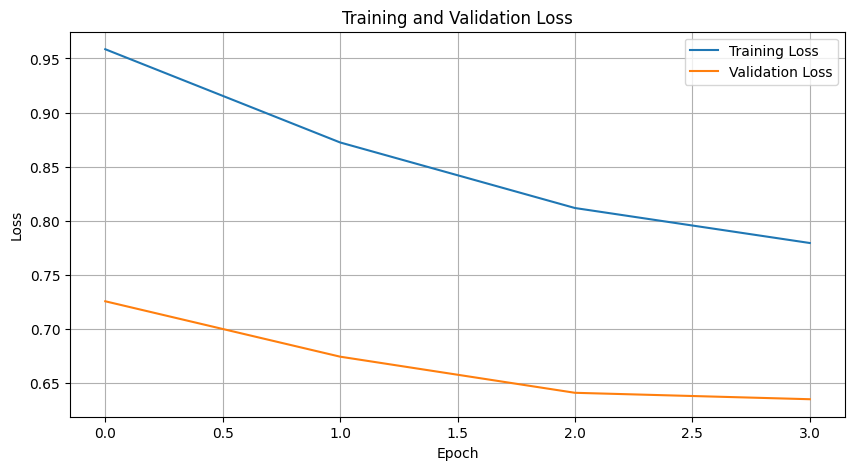

In [13]:
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


In [17]:
def evaluate(model, loader):
    model.eval()
    y_true_cls, y_pred_cls = [], []
    with torch.no_grad():
        for batch in loader:
            if batch is None:
                continue
            raw_seqs, oh_tensor, y_cls, _ = batch
            oh_tensor = oh_tensor.to(DEVICE)
            preds, _ = model(raw_seqs, oh_tensor)
            preds = (preds.squeeze().cpu().numpy() > 0.5).astype(int)

            y_pred_cls.extend(preds.tolist())
            y_true_cls.extend(y_cls.numpy().tolist())

    # Calculate F1 score
    f1 = f1_score(y_true_cls, y_pred_cls)
    return f1

val_f1 = evaluate(model, val_loader)
print(f"Validation F1 Score: {val_f1:.3f}")

Validation F1 Score: 0.701
